## Time to get you hands dirty!  Position of a quasar

In [1]:
import numpy as np
import scipy.stats
import pylab as plt

from astropy.stats import median_absolute_deviation
from astroML import stats as astroMLstats

from tqdm import tqdm

You measure the position of a quasar $N$ times with the *same* telescope i.e. errors are homoscedastic. Let's say the underlying process is Gaussian, the true position is $\mu = 1$ (in suitable units), and the erorrs are $\sigma=0.2$

### Part 1

- Generate fake measurements. Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.



In [2]:
# Homoscedastic errors, Gaussian underlying process:
mu = 1
sigma = 0.2

# generate fake measurements: each one is an observation with uncertainty sigma=0.2
N_meas = 100
gauss_meas = np.zeros([N_meas],dtype=object)
random_mu = np.zeros(N_meas)

for i in range(N_meas):
    random = np.random.normal(mu,sigma)
    random_mu[i] = random
    gauss_meas[i] = scipy.stats.norm(random,sigma) 


- Plot each of the individual likelihoods separately.  Also plot their product (i.e. the likelihood of the dataset $\{x_i\}$). Make sure the x grid has enough points.

Text(0, 0.5, '$pdf(\\mu)$')

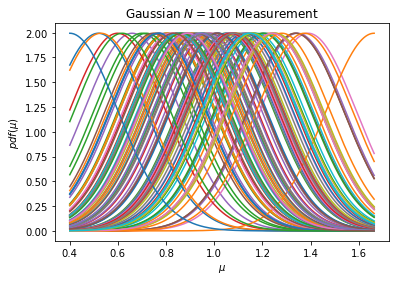

In [3]:
# compute the pdf's and plot the results
x_grid = np.linspace(min(random_mu),max(random_mu),1000)
pdf = np.empty([N_meas],dtype=object)

for i in range(N_meas):
    pdf[i] = gauss_meas[i].pdf(x_grid)
    plt.plot(x_grid,pdf[i])
    
plt.title(r'Gaussian $N=%i$ Measurement'%N_meas)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$pdf(\mu)$')

We can compute the Likelihood as the product of the pdf's representing the single measurements:

$$L \equiv p(\{x_i\}|M(\theta)) = \prod_{i=1}^N p(x_i|M(\theta)),$$

- Just read off the maximum likelihood solution (e.g. using `np.argmax`) 
- Compare it with the MLE estimator derived above:

$$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i,$$


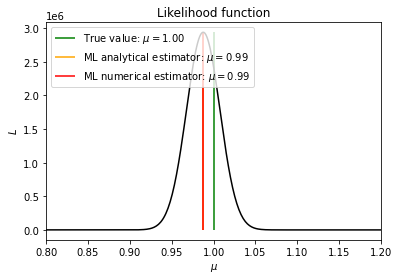

In [4]:
# compute the Likelihood
Likelihood = np.prod(pdf)

# x at which we have the maximum Likelihood
x_maxL = x_grid[np.argmax(Likelihood)]

# analytical ML estimator:
mu_MLE = np.sum(random_mu)/N_meas 

# plot the Likelihood:
plt.plot(x_grid,Likelihood,color='black')
plt.title('Likelihood function')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$L$')
plt.xlim(0.8,1.2)
#plt.ylim(-1e5,max(Likelihood+5e5))
plt.vlines(mu,min(Likelihood),max(Likelihood),color='green',label='True value: $\mu=%.2f$'%mu)
plt.vlines(mu_MLE,min(Likelihood),max(Likelihood),color='orange',label='ML analytical estimator: $\mu=%.2f$'%mu_MLE)
plt.vlines(x_maxL,min(Likelihood),max(Likelihood),color='red',label='ML numerical estimator: $\mu=%.2f$'%x_maxL)
plt.legend(loc='upper left')

### Part 2

Check the Fisher matrix error estimate makes sense:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{d^2 \ln L}{d\theta_j d\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.grad`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.

In [5]:
# compute the log-Likelihood 
log_L = np.log(Likelihood)

# compute the deriative respect to mu
d2_lnL = np.gradient(np.gradient(log_L))
d_theta = np.gradient(x_grid)

d2_lnL_dtheta2 = d2_lnL/(d_theta**2)

# compute the Fisher matrix
Fisher_mat = - d2_lnL_dtheta2

# compute the uncertainty:
sigmas = np.sqrt(1/Fisher_mat) # this is the sigma point by point
sigma_mu = sigmas[np.argmax(log_L)]

- Compare with the Fisher matrix error derived above:

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

In [6]:
print('Numerical sigma ML:',sigma_mu)
print('Analytical sigma ML:',sigma/np.sqrt(N_meas))

Numerical sigma ML: 0.020000000000001
Analytical sigma ML: 0.02


- Plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution. (The normalization won't be captured, you can rescale it as you like to check it agrees) 

Text(0.5, 1.0, 'Likelihood vs Gauss($\\hat{\\mu},\\sigma_\\mu$)')

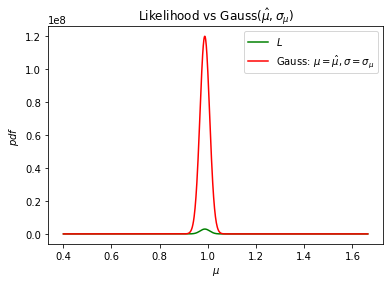

In [7]:
# gaussian at measured mu with its error as the scale
gauss_MLE = scipy.stats.norm(x_maxL,sigma_mu)

# plot
plt.plot(x_grid,Likelihood,color='green',label='$L$')
plt.plot(x_grid,gauss_MLE.pdf(x_grid)*6e6,color='red',label='Gauss: $\mu=\hat{\mu}, \sigma=\sigma_\mu$')
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$pdf$')
plt.title('Likelihood vs Gauss($\hat{\mu},\sigma_\mu$)')

### Part 3

Let's make our model more realistic. Our $N$ measurements were taken in different nights, where the sky behaved differently (i.e. errors are heteoscedastic). Let's assume that each measurment has a $\sigma_i$ that is normally distribured with mean $0.2$ and standard deviation $0.05$

- Generalize your code from above to this case

For an Heteroscedastic Gaussian, the ML estimators for the mean value and the standard deviation are:

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [8]:
# Heteroscedastic errors, Gaussian underlying process:
mu = 1
sigma = 0.2
sigma_std = 0.05

# generate fake measurements: each one is an observation with uncertainty draws from a normal distribution N(0.2,0.05)
N_meas = 100
gauss_meas = np.zeros([N_meas],dtype=object)
random_mu = np.zeros(N_meas)
random_sigma = np.zeros(N_meas)

for i in range(N_meas):
    # extract random mu:
    m_random = np.random.normal(mu,sigma)
    random_mu[i] = m_random
    # extraxt random sigma
    s_random = np.random.normal(sigma,sigma_std)
    random_sigma[i] = s_random
    # build the Gaussian
    gauss_meas[i] = scipy.stats.norm(m_random,s_random) 


Text(0, 0.5, '$pdf(\\mu)$')

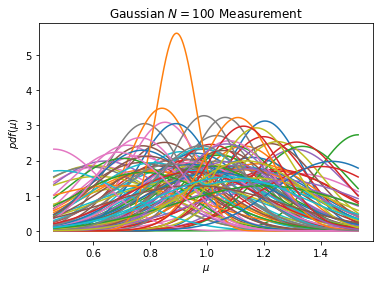

In [9]:
# compute the pdf's and plot the results
x_grid = np.linspace(min(random_mu),max(random_mu),1000)
pdf = np.empty([N_meas],dtype=object)

for i in range(N_meas):
    pdf[i] = gauss_meas[i].pdf(x_grid)
    plt.plot(x_grid,pdf[i])
    
plt.title(r'Gaussian $N=%i$ Measurement'%N_meas)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$pdf(\mu)$')

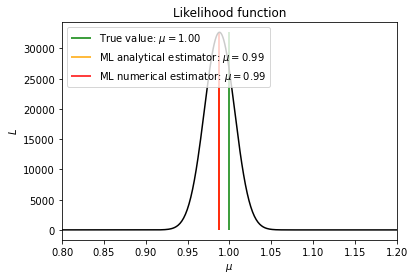

In [10]:
# compute the Likelihood
Likelihood = np.prod(pdf)

# x at which we have the maximum Likelihood
x_maxL = x_grid[np.argmax(Likelihood)]

# analytical ML estimator:
mu_MLE = np.sum(random_mu/(random_sigma)**2)/np.sum((1/random_sigma**2)) 

# plot the Likelihood:
plt.plot(x_grid,Likelihood,color='black')
plt.title('Likelihood function')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$L$')
plt.xlim(0.8,1.2)
#plt.ylim(-1e7,max(Likelihood+3.5e7))
plt.vlines(mu,min(Likelihood),max(Likelihood),color='green',label='True value: $\mu=%.2f$'%mu)
plt.vlines(mu_MLE,min(Likelihood),max(Likelihood),color='orange',label='ML analytical estimator: $\mu=%.2f$'%mu_MLE)
plt.vlines(x_maxL,min(Likelihood),max(Likelihood),color='red',label='ML numerical estimator: $\mu=%.2f$'%x_maxL)
plt.legend(loc='upper left')

In [11]:
# compute the log-Likelihood 
log_L = np.log(Likelihood)

# compute the deriative respect to mu
d2_lnL = np.gradient(np.gradient(log_L))
d_theta = np.gradient(x_grid)

d2_lnL_dtheta2 = d2_lnL/(d_theta**2)

# compute the Fisher matrix
Fisher_mat = - d2_lnL_dtheta2

# compute the uncertainty:
sigmas = np.sqrt(1/Fisher_mat) # this is the sigma point by point
sigma_mu = sigmas[np.argmax(log_L)]

In [12]:
print('Numerical sigma ML:',sigma_mu)
print('Analytical sigma ML:',(np.sum(1/random_sigma**2))**(-1/2))

Numerical sigma ML: 0.01805368969371951
Analytical sigma ML: 0.018053689693721002


Text(0.5, 1.0, 'Likelihood vs Gauss($\\hat{\\mu},\\sigma_\\mu$)')

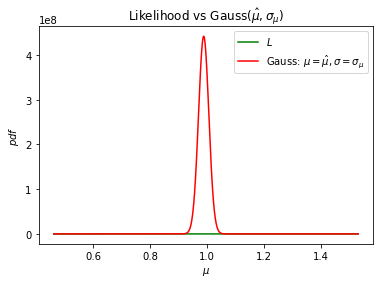

In [13]:
# gaussian at measured mu with its error as the scale
gauss_MLE = scipy.stats.norm(x_maxL,sigma_mu)

# plot
plt.plot(x_grid,Likelihood,color='green',label='$L$')
plt.plot(x_grid,gauss_MLE.pdf(x_grid)*2e7,color='red',label='Gauss: $\mu=\hat{\mu}, \sigma=\sigma_\mu$')
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$pdf$')
plt.title('Likelihood vs Gauss($\hat{\mu},\sigma_\mu$)')

Let's try to study how the MLE estimators approaches the consistency as the number of 'measurements' increases:

In [22]:
N_meas_arr = np.array([10,50,100,500,1000,2000,3000,4000,5000])

# Heteroscedastic errors, Gaussian underlying process:
mu = 1
sigma = 0.2
sigma_std = 0.05

# generate fake measurements: each one is an observation with uncertainty draws from a normal distribution N(0.2,0.05)
gauss_meas = np.zeros([len(N_meas_arr)],dtype=object)
random_mu = np.zeros([len(N_meas_arr)],dtype=object)
random_sigma = np.zeros([len(N_meas_arr)],dtype=object)

for i in range(len(N_meas_arr)):
    
    gauss_meas[i] = np.zeros(N_meas_arr[i],dtype=object)
    random_mu[i] = np.zeros(N_meas_arr[i])
    random_sigma[i] = np.zeros(N_meas_arr[i])
    
    for j in range(N_meas_arr[i]):
        
        # extract random mu:
        m_random = np.random.normal(mu,sigma)
        random_mu[i][j] = m_random
        # extraxt random sigma
        s_random = np.random.normal(sigma,sigma_std)
        random_sigma[i][j] = s_random
        # build the Gaussian
        gauss_meas[i][j] = scipy.stats.norm(m_random,s_random) 


In [23]:
# compute the Likelihood
Likelihood_arr = np.zeros(len(N_meas_arr),dtype=object)

# compute the MLE mu estimator
mu_MLE_arr = np.zeros(len(N_meas_arr))
mu_an_arr = np.zeros(len(N_meas_arr))

# compute the uncertainties
sigma_MLE_arr = np.zeros(len(N_meas_arr))
sigma_an_arr = np.zeros(len(N_meas_arr))

for i in tqdm(range(len(N_meas_arr))):
    x_grid = np.linspace(min(random_mu[i]),max(random_mu[i]),10000)
    pdf = np.empty([N_meas_arr[i]],dtype=object)

    for j in range(N_meas_arr[i]):
        pdf[j] = gauss_meas[i][j].pdf(x_grid)
    
    # Likelihood --------------------------------------------------------------------------------------
    Likelihood_arr[i] = np.prod(pdf)
    
    # numerical maximum Likelihood -> mu --------------------------------------------------------------
    mu_MLE_arr[i] = x_grid[np.argmax(Likelihood_arr[i])]
    
    # analytical ML mu estimator:
    mu_an_arr[i] = np.sum(random_mu[i]/(random_sigma[i])**2)/np.sum((1/random_sigma[i]**2)) 
    
    # uncertainty estimate ----------------------------------------------------------------------------
    
    # compute the log-Likelihood 
    log_L = np.log(Likelihood_arr[i])

    # compute the derivative respect to mu
    d2_lnL = np.gradient(np.gradient(log_L))
    d_theta = np.gradient(x_grid)

    d2_lnL_dtheta2 = d2_lnL/(d_theta**2)

    # compute the Fisher matrix
    Fisher_mat = - d2_lnL_dtheta2

    # compute the uncertainty:
    sigmas = np.sqrt(1/Fisher_mat) # this is the sigma point by point
    sigma_MLE_arr[i] = sigmas[np.argmax(log_L)]
    
    # analitycal sigma MLE:
    sigma_an_arr[i] = (np.sum(1/random_sigma[i]**2))**(-1/2)

 33%|███▎      | 3/9 [00:00<00:00, 25.60it/s]<ipython-input-23-31cd73f1e6f8>:31: RuntimeWarning: divide by zero encountered in log
  log_L = np.log(Likelihood_arr[i])
C:\Users\Ludovico\anaconda3\lib\site-packages\numpy\lib\function_base.py:1211: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\Ludovico\anaconda3\lib\site-packages\numpy\lib\function_base.py:1232: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
C:\Users\Ludovico\anaconda3\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
<ipython-input-23-31cd73f1e6f8>:43: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(1/Fisher_mat) # this is the sigma point by point
100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


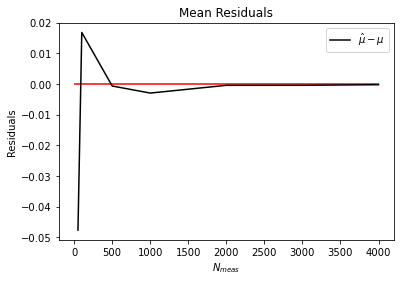

In [28]:
plt.plot(N_meas_arr[1:-1],mu_MLE_arr[1:-1]-mu,color='black',label='$\\hat{\mu}-\mu$')
plt.hlines(mu-mu,0,4000,color='red')

plt.title('Mean Residuals')
plt.ylabel('Residuals')
plt.xlabel('$N_{meas}$')
plt.legend()

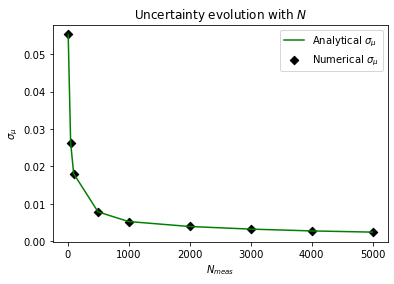

In [30]:
plt.scatter(N_meas_arr,sigma_MLE_arr,marker='D',color='black',label='Numerical $\sigma_\mu$')
plt.plot(N_meas_arr,sigma_an_arr, label='Analytical $\sigma_{\mu}$',color='green')

plt.title('Uncertainty evolution with $N$')
plt.xlabel('$N_{meas}$')
plt.ylabel('$\sigma_\mu$')
plt.legend()